# Graph Signal Processing using TV regularization

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, plotting
from sklearn.metrics import mean_squared_error
import pyunlocbox
from random import sample

DATA_PATH = 'datasets/'
adjacency = np.loadtxt(DATA_PATH+'movie_ratings_adj.csv', delimiter=',')
ratings = pd.read_csv(DATA_PATH+'ratings_matrix.csv', index_col=0)

## Small network

### Test with one user
To begin we just use the first signal (the first user)

In [92]:
signal = ratings.loc[1].reset_index(drop = True)
indexes = np.array(signal1[signal1 >0].index.to_list())

We use the first 250 movies which are all rated by this user. So we can see the evolution of the MSE with the percentage of missing ratings

In [86]:
adj = adjacency[indexes][:, indexes]
signal1 = signal1[indexes]
G = graphs.Graph(adj)
G.set_coordinates()

/Users/lamborellemaxime/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


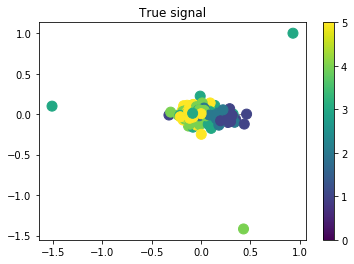

In [87]:
G.plot_signal(signal1, limits=[0,5], plot_name="True signal")

In [88]:
def tv_reg(G, noisy, mask):
    # Set the functions in the problem
    gamma = 3.0
    d = pyunlocbox.functions.dummy()
    r = pyunlocbox.functions.norm_l1()
    f = pyunlocbox.functions.norm_l2(w=mask, y=noisy, lambda_=gamma)

    # Define the solver
    G.compute_differential_operator()
    L = G.D.toarray()
    step = 0.999 / (1 + np.linalg.norm(L))
    solver = pyunlocbox.solvers.mlfbf(L=L, step=step)

    # Solve the problem
    x0 = noisy.copy()
    prob1 = pyunlocbox.solvers.solve([d, r, f], solver=solver, x0=x0, rtol=0, maxit=1000, verbosity='NONE')

    return prob1['sol']

Mean squared error:  0.25040256898593044


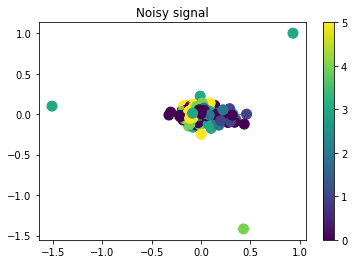

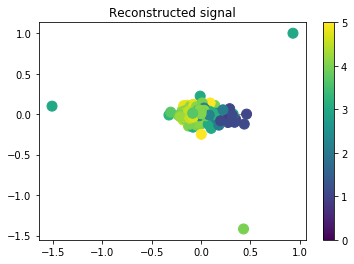

In [89]:
# Create the mask
rs = np.random.RandomState(42)
M = rs.rand(G.N)
M = (M > 0.3).astype(float)
noisy = signal1 * M
G.plot_signal(noisy, limits=[0,5], plot_name="Noisy signal")
reconstructed = tv_reg(G, noisy, M)
G.plot_signal(reconstructed, limits=[0,5], plot_name="Reconstructed signal")
print("Mean squared error: ", mean_squared_error(signal1, reconstructed))

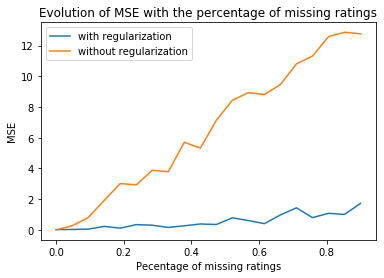

In [90]:
missing = np.linspace(0, 0.9, 20)
errors = []
errors_without_reg = []
rs = np.random.RandomState()
for missing_percentage in missing:
    # Create the mask
    M = rs.rand(G.N)
    M = (M > missing_percentage).astype(float)
    noisy = signal1 * M
    # Compute errors
    errors.append(mean_squared_error(signal1, tv_reg(G, noisy, M)))
    errors_without_reg.append(mean_squared_error(signal1, noisy))

plt.figure()
plt.plot(missing, errors, label="with regularization")
plt.plot(missing, errors_without_reg, label="without regularization")
plt.title("Evolution of MSE with the percentage of missing ratings")
plt.xlabel("Pecentage of missing ratings")
plt.ylabel("MSE")
plt.legend()
plt.show()

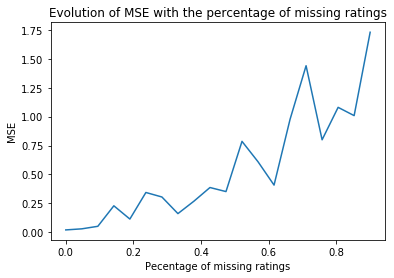

In [91]:
plt.figure()
plt.plot(missing, errors, label="with regularization")
plt.title("Evolution of MSE with the percentage of missing ratings")
plt.xlabel("Pecentage of missing ratings")
plt.ylabel("MSE")
plt.show()

We can see that the regularization helps a lot and that we obtain very good results event for high percentage of missing ratings

### Test over all users

In [93]:
errors = np.ndarray(shape=(len(ratings), 20))
errors_without_reg = np.ndarray(shape=(len(ratings), 20))
rs = np.random.RandomState(42)

In [ ]:
missing = np.linspace(0, 0.9, 20)
for i, (idx, sig) in enumerate(ratings.iterrows()):
    # Create small graph
    signal = sig.reset_index(drop = True)
    indexes = np.array(signal1[signal1 >0].index.to_list())
    adj = adjacency[indexes][:, indexes]
    signal = signal[indexes]
    G = graphs.Graph(adj)
    G.set_coordinates()
    # compute errors for all percentages of missing ratings
    for j, missing_percentage in enumerate(missing):
        # Create the mask
        M = rs.rand(G.N)
        M = (M > missing_percentage).astype(float)
        noisy = signal * M
        # Compute errors
        errors[i, j] = mean_squared_error(signal, tv_reg(G, noisy, M))
        errors_without_reg[i ,j] = mean_squared_error(signal, noisy)

In [ ]:
plt.figure()
plt.plot(missing, np.mean(errors, axis=1), label="with regularization")
plt.plot(missing, np.mean(errors_without_reg, axis=1), label="without regularization")
plt.title("Evolution of MSE with the percentage of missing ratings")
plt.xlabel("Pecentage of missing ratings")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(missing, np.mean(errors, axis=1), label="with regularization")
plt.title("Evolution of MSE with the percentage of missing ratings")
plt.xlabel("Pecentage of missing ratings")
plt.ylabel("MSE")
plt.show()

## Entire network

### Test with one user

We will now try with the whole network (still for the first user). The principle is really the same but we have to carefully design the mask. Indeed the mask must be 0 for every unknown entry and 30% of known entry and 1 elsewhere.

In [47]:
signal1 = ratings.loc[1]
signal1

1       5
2       3
3       4
4       3
5       3
       ..
1615    0
1651    0
1654    0
1664    0
1680    0
Name: 1, Length: 480, dtype: int64

In [48]:
def create_mask(signal, percentage):
    mask = signal.copy()
    mask[mask > 0] = 1
    indexes = sample(mask[mask > 0].index.to_list(), int(len(mask[mask>0])*percentage))
    mask[indexes] = 0
    return mask

In [49]:
# Load graph
G = graphs.Graph(adjacency)
G.set_coordinates()

In [50]:
# create mask
mask = create_mask(signal1, 0.3)
noisy = signal1 * mask

/Users/lamborellemaxime/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


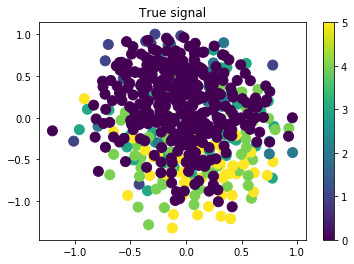

In [51]:
G.plot_signal(signal1, limits=[0,5], plot_name="True signal")

In [52]:
reconstructed = tv_reg(G, noisy, mask)

In [53]:
test_mask = create_mask(signal1, 0)
mean_squared_error(signal1, reconstructed*test_mask)

2.847916666666667

### Test over all users
Now we will test the TV regularization over all users. Each of them reprensent a signal lying on the graph. We will use a test set of 30% of the rated movie for all users

In [55]:
errors = []
for idx, signal in ratings.iterrows():
    mask = create_mask(signal, 0.3)
    noisy = signal * mask
    reconstructed = tv_reg(G, noisy, mask)
    test_mask = create_mask(signal1, 0)
    errors.append(mean_squared_error(signal, reconstructed*test_mask))

In [56]:
print("Mean square error :", np.mean(errors))

Mean square error : 1.392249911629551
